In [1]:
%load_ext autoreload
%autoreload 2
from dateutil import rrule
from datetime import date, datetime, timedelta
import pandas as pd
import pickle as pkl
import random
import matplotlib.pyplot as plt
import fastplot
import seaborn as sns
import scipy
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import itertools
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics.cluster import normalized_mutual_info_score

# WhatsApp

**NMI Communities**

In [2]:
list_models = ['Original', 'DF', 'polya', 'threshold', 'hss', 'recast']
dict_names = {'Original': 'Original Network', 'DF':'DF’s backbone', 'hss':'HSS’s backbone',
              'polya':'Polya’s backbone', 'threshold':"Threshold’s backbone", 'recast':'RECAST’s backbone'}

threshold = 0.950
disparityfilter = 0.95 
polya = 0.05
hss = 0.95
recast = 0.05
original = -1 #Doesnt exist parameter

dict_map_parameter = {'Original':'',  'threshold':threshold, 'DF':disparityfilter, 'hss':hss, 'polya':polya, 'recast':recast}

PATH_Networks = 'WhatsApp/backbones/'
PATH_Communities = 'WhatsApp/communities/'
k = 'October'
list_results = []
for model_1 in list_models:
    for model_2 in list_models:
        if model_1 == 'Original':
            comm_1 = pkl.load(open(PATH_Communities+model_1+k+'.pkl', "rb")) 
        else:
            comm_1 = pkl.load(open(PATH_Communities+model_1+k+'-'+str(dict_map_parameter[model_1])+'.pkl', "rb")) 

        if model_2 == 'Original':
            comm_2 = pkl.load(open(PATH_Communities+model_2+k+'.pkl', "rb")) 
        else:
            comm_2 = pkl.load(open(PATH_Communities+model_2+k+'-'+str(dict_map_parameter[model_2])+'.pkl', "rb")) 

        comm_1 = {int(k):int(v) for k,v in comm_1.items()}
        comm_2 = {int(k):int(v) for k,v in comm_2.items()}
        common_nodes = set(comm_1.keys()) & set(comm_2.keys())
        list_id_1 = []
        list_id_2 = []
        for node in common_nodes:
            list_id_1.append(comm_1[node])
            list_id_2.append(comm_2[node])
        if len(common_nodes) == 0:
            nmi = 0
            print(model_1, model_2)
        else:
            nmi = round(normalized_mutual_info_score(list_id_1, list_id_2),4)
        list_results.append((dict_names[model_1], dict_names[model_2], nmi))
df = pd.DataFrame(list_results, columns = ['Model 1', 'Model 2', 'NMI'])

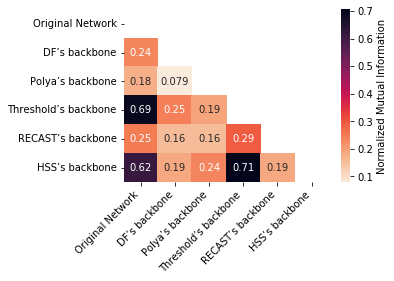

In [3]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 4))
sorter = ['Original Network', 'DF’s backbone', 'Polya’s backbone', 'Threshold’s backbone',  'RECAST’s backbone', 'HSS’s backbone', ]
pivot = df.pivot_table(index='Model 2', columns='Model 1', values='NMI')
mask = np.zeros(pivot.shape)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(pivot, 
                 annot=True,cbar_kws={'label': 'Normalized Mutual Information'}, 
                 mask=mask, cmap='rocket_r', xticklabels=sorter, yticklabels=sorter)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
fig.tight_layout()
fig.savefig('WhatsApp/plots/'+k+'-NMI.pdf')

**Edge Weight Distribution**

In [4]:
list_models = ['Original', 'DF', 'polya', 'threshold', 'hss', 'recast']
dict_names = {'Original': 'Original Network', 'DF':'DF’s backbone', 'hss':'HSS’s backbone',
              'polya':'Polya’s backbone', 'threshold':"Threshold’s backbone", 'recast':'RECAST’s backbone'}

threshold = 0.950
disparityfilter = 0.95 
polya = 0.05
hss = 0.95
recast = 0.05
original = -1 #Doesnt exist parameter



PATH_Networks = 'WhatsApp/backbones/'
k = 'October'
list_edge_weight_dist = []

#Original network
df = pd.read_csv('WhatsApp/networks/'+k+'.edgelist', names=['src', 'trg', 'nij', 'src_n', 'trg_n'], delimiter=' ')
list_edge_weight_dist.append(("Original Network", list(df['nij'])))


#DF
df = pd.read_csv(PATH_Networks+'df/'+k+'.edgelist', sep=',', names=['src', 'trg', 'nij', 'score', 'v'])
df = df[df['score'] > disparityfilter]
list_edge_weight_dist.append(("DF's backbone", list(df['nij'])))


# Polya Urn
df = pd.read_csv(PATH_Networks+'polya/'+k+'.edgelist', sep=',', names=['src', 'trg', 'nij', 'p_value'])
df = df[df['p_value'] < polya]
list_edge_weight_dist.append(("Polya's backbone", list(df['nij'])))


#HSS
df = pd.read_csv(PATH_Networks+'hss/'+k+'.edgelist', sep=',', names=['src', 'trg', 'nij', 'score'])
value = np.percentile(list(df['score']), hss*100)
df = df[df['score'] > value]
list_edge_weight_dist.append(("HSS's backbone", list(df['nij'])))


#Thresholding
df = pd.read_csv('WhatsApp/networks/'+k+'.edgelist', names=['src', 'trg', 'nij', 'src_n', 'trg_n'], delimiter=' ')
value = np.percentile(list(df['nij']),threshold*100)
df = df[df['nij'] > value]
list_edge_weight_dist.append(("Threshold's backbone", list(df['nij'])))


#Recast
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/recast/' 
snap ='October'
iteraction = '1'
file_Node_Map = 'RECAST/RECAST/traces/whatsapp/whatsapp-'+iteraction+'_nodetable.dat'

df = pd.read_csv('WhatsApp/backbones/recast/October-'+str(recast)+'.edgelist', delimiter=' ')
df.columns = ['src', 'trg', 'nij', 'src_n', 'trg_n']
df= df[['src', 'trg', 'nij']]
list_edge_weight_dist.append(("RECAST's backbone", list(df['nij'])))


**Dist Plot** 

In [6]:
list_results = []
for model, dist in list_edge_weight_dist:
    for v in dist:
        list_results.append((model, v))
df = pd.DataFrame(list_results, columns=['Model', 'Edge Weight'])
df['Edge Weight'] = df['Edge Weight'].astype(int)

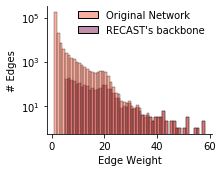

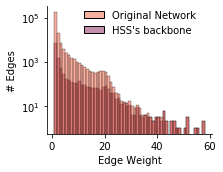

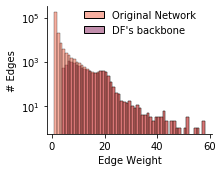

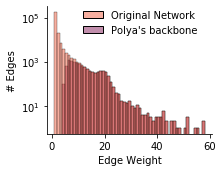

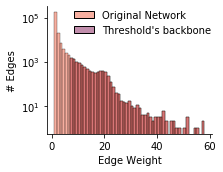

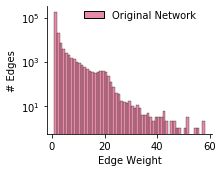

In [7]:
%matplotlib inline
sns.reset_orig()
    
for model in set(df['Model']):
    if model != 'Original':
        g=sns.displot(df[df['Model'].isin(['Original Network', model])],  height=2.5, aspect=1.3,
                    x="Edge Weight", hue="Model", binwidth=1, palette= "rocket_r", #stat = 'density',
                    log_scale=(False, True), legend=True)
        sns.move_legend(g, "upper right", bbox_to_anchor=(.58, 0.95), ncol=1, title=None, frameon=False)
        g.set(xlabel='Edge Weight', ylabel='# Edges')
        g.savefig('WhatsApp/plots/'+model+'-Edge Weight Distributions.pdf')